# Process Bayesian inference results

>! To run this notebook, first copy the contents of `NeuralOperator_Survey_Shared_Data_March2025/survey_work/applications/bayesian_inverse_problem_poisson/Results/ground_truth` inside `../Results/ground_truth/`. Also, copy the folders `NeuralOperator_Survey_Shared_Data_March2025/survey_work/applications/bayesian_inverse_problem_poisson/processed_results/[FINAL*]` inside `./'.

In [4]:
import sys
import os
import time
import pickle
import numpy as np
import dolfin as dl

from scipy.interpolate import griddata



src_path = "../../../../src/"
sys.path.append(src_path + 'plotting')
from field_plot import *
from plot_mix_collection import *
from point_plot import *
from plot_curve import plot_curve

sys.path.append(src_path + 'pde')
sys.path.append(src_path + 'prior')
from priorSampler import PriorSampler

model_path = "../../../problems/poisson/"
sys.path.append(model_path)
from poissonModel import PoissonModel



sys.path.append(src_path + 'mcmc')
from mcmc import MCMC
from mcmc_plot_fields import mcmc_plot_fields, mcmc_plot_fields_base
from compute_sample_errors import compute_sample_errors
from surrogateModel import SurrogateModel, SurrogateModelFNO

sys.path.append(src_path + 'nn/deeponet')
sys.path.append(src_path + 'data/')
sys.path.append(src_path + 'nn/mlp')
from load_data_and_deeponet import load_data_and_deeponet

sys.path.append(src_path + 'nn/pcanet')
from load_data_and_pcanet import load_data_and_pcanet

sys.path.append(src_path + 'nn/fno')
from load_data_and_fno import load_data_and_fno

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

# set seed
seed = 0
np.random.seed(seed)

In [2]:
model_data_folder = model_path + 'data/'
bayesian_results_dir = '../Results/'
current_directory = os.getcwd()  
results_dir = current_directory + '/Results/'
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

# Create model and MCMC objects

In [3]:
prior_ac = 0.005
prior_cc = 0.2
prior_logn_scale = 1
prior_logn_translate = 0.
nx, ny = 50, 50
fe_order = 1
data_prefix = 'Poisson'

# create mesh
mesh = dl.UnitSquareMesh(nx, ny)

# create function spaces
Vm = dl.FunctionSpace(mesh, 'Lagrange', fe_order)
Vu = Vm

# create prior sampler
prior_sampler = PriorSampler(Vm, prior_ac, prior_cc, seed)

# create model
model = PoissonModel(Vm, Vu, prior_sampler, prior_logn_scale, prior_logn_translate, seed)

# Load Neural Operators

In [5]:
def load_deeponet():
    data_path = model_path + 'data/' + 'Poisson_samples.npz'
    nn_path = model_path + 'DeepONet/Results/model.pkl'
    data, nn = load_data_and_deeponet(data_path, nn_path)
    nn_surrogate = SurrogateModel(model, nn, data)
    print('nn_data: ', data)
    print('nn_model: ', nn)

    return nn_surrogate

def load_pcanet():
    data_path = model_path + 'data/' + 'Poisson_samples.npz'
    nn_path = model_path + 'PCANet/Results/model.pkl'
    data, nn = load_data_and_pcanet(data_path, nn_path)
    nn_surrogate = SurrogateModel(model, nn, data)
    print('nn_data: ', data)
    print('nn_model: ', nn)

    return nn_surrogate

def load_fno():
    data_path = model_path + 'data/' + 'Poisson_FNO_samples.npz'
    nn_path = model_path + 'FNO/Results/model.pkl'
    data, nn = load_data_and_fno(data_path, nn_path)
    # get some additional data for FNO
    nodes = deeponet.data.X_trunk
    grid_x = data.grid_x_test[0, :, :, 0]
    grid_y = data.grid_y_test[0, :, :, 0]
    nn_surrogate = SurrogateModelFNO(model, nn, data, nodes, grid_x, grid_y, u_comps = 1)
    print('nn_data: ', data)
    print('nn_model: ', nn)

    return nn_surrogate

deeponet = load_deeponet()
pcanet = load_pcanet()
fno = load_fno()

surrogate_models = {'DeepONet': deeponet, 'PCANet': pcanet, 'FNO': fno}

nn_data:  <dataMethods.DataProcessor object at 0x7010863f6a90>
nn_model:  DeepONet(
  (branch_net): MLP(
    (layers): ModuleList(
      (0): Linear(in_features=2601, out_features=64, bias=True)
      (1): Linear(in_features=64, out_features=64, bias=True)
      (2): Linear(in_features=64, out_features=100, bias=True)
    )
  )
  (trunk_net): MLP(
    (layers): ModuleList(
      (0): Linear(in_features=2, out_features=64, bias=True)
      (1): Linear(in_features=64, out_features=64, bias=True)
      (2): Linear(in_features=64, out_features=100, bias=True)
    )
  )
)
nn_data:  <dataMethods.DataProcessor object at 0x700e8c1c2ed0>
nn_model:  PCANet(
  (net): MLP(
    (layers): ModuleList(
      (0): Linear(in_features=100, out_features=250, bias=True)
      (1-2): 2 x Linear(in_features=250, out_features=250, bias=True)
      (3): Linear(in_features=250, out_features=100, bias=True)
    )
  )
)
nn_data:  <dataMethods.DataProcessorFNO object at 0x700ed6541b50>
nn_model:  FNO2D(
  (fno_lay

# Get ground truth

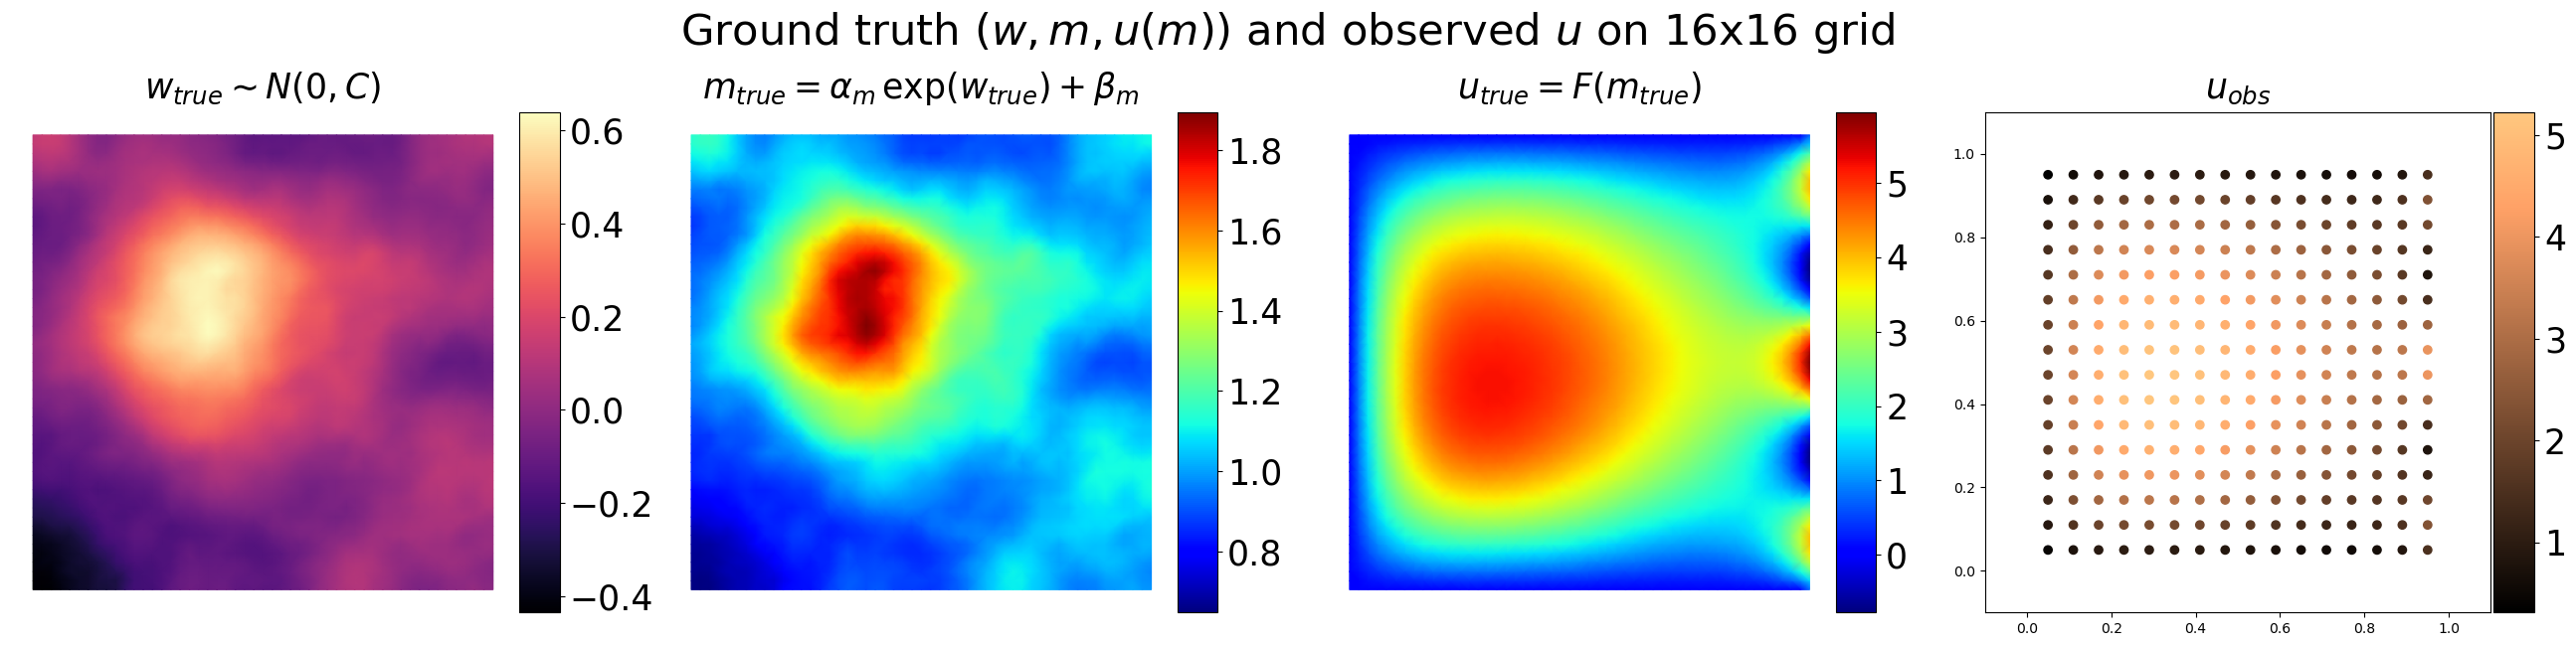

In [6]:
# load
ground_truth_data = np.load(bayesian_results_dir + 'ground_truth/data.npz')
num_grid_x, num_grid_y = ground_truth_data['num_grid_x'], ground_truth_data['num_grid_y']
w_true = ground_truth_data['w_true']
m_true = ground_truth_data['m_true']
u_true = ground_truth_data['u_true']
x_obs = ground_truth_data['x_obs']
u_obs = ground_truth_data['u_obs']


rows, cols = 1, 4
fig, axs = plt.subplots(rows, cols, figsize=(26, 6))
axs = np.array([axs]) if rows == 1 else axs

uvec = [[w_true, m_true, u_true]]
title_vec = [[r'$w_{true} \sim N(0, C)$', r'$m_{true} = \alpha_m\, \exp(w_{true}) + \beta_m$', r'$u_{true} = F(m_{true})$', r'$u_{obs}$']]
cmap_vec = [['magma', 'jet', 'jet', 'copper']]
sup_title = r'Ground truth $(w, m, u(m))$ and observed $u$ on {}x{} grid'.format(num_grid_x, num_grid_y)
fs = 25
y_sup_title = 1.075
savefilename = results_dir + 'true_and_obs_w_m_u.png'

nodes = model.Vm.mesh().coordinates()


for i in range(rows):
    for j in range(cols):

        # add grid points
        if j == cols - 1:
            axs[i,j].set_xlim([-0.1, 1.1])
            axs[i,j].set_ylim([-0.1, 1.1])
        
        if j < cols - 1:
            cbar = field_plot(axs[i,j], \
                uvec[i][j], \
                nodes, cmap = cmap_vec[i][j])
        else:
            cbar = point_plot(axs[i,j], u_obs, x_obs, cmap = cmap_vec[i][j])
        divider = make_axes_locatable(axs[i,j])
        cax = divider.append_axes('right', size='8%', pad=0.03)
        cax.tick_params(labelsize=fs)
        cbar = fig.colorbar(cbar, cax=cax, orientation='vertical')
        if j < cols - 1:
            axs[i,j].axis('off')
        if title_vec is not None:
            axs[i,j].set_title(title_vec[i][j], fontsize=fs, pad=10)        

fig.tight_layout()
if sup_title is not None:
    fig.suptitle(sup_title, fontsize=1.25*fs, y = y_sup_title)
if savefilename is not None:
    plt.savefig(savefilename,  bbox_inches='tight')
plt.show()

# Load true model results

In [7]:
## noise
u_obs_mean, u_obs_std = np.mean(u_obs), np.std(u_obs)
sigma_noise = 0.05 * u_obs_mean
print('u_obs_mean = {:.3e}, u_obs_std = {:.3e}, sigma_noise: {:.3e}'.format(u_obs_mean, u_obs_std, sigma_noise))

u_obs_mean = 2.785e+00, u_obs_std = 1.329e+00, sigma_noise: 1.393e-01


In [8]:
## create MCMC object
surrogate_to_use = None

n_samples = 10000
n_burnin = 500
pcn_beta = 0.2
print_every = 100
display_plot_every = 5*print_every

savepath_base = 'FINAL_mcmc_results_n_samples_{:d}_n_burnin_{:d}_pcn_beta_{:.3f}_sigma_{:.3e}'.format(n_samples, n_burnin, pcn_beta, sigma_noise)

savepath_true = savepath_base + '/'
savefilename = 'tracer'
model_tag = 'True'

mcmc = MCMC(model, prior_sampler, ground_truth_data, \
            sigma_noise = sigma_noise, pcn_beta = 0.2, \
            surrogate_to_use = surrogate_to_use, \
            surrogate_models = surrogate_models, \
            seed = seed)

In [9]:
## load tracer data
tracer_true = pickle.load(open(savepath_true + savefilename + '.pkl', 'rb'))
tracer_true.acceptances, tracer_true.acceptance_rate

(160,
 array([0.        , 0.        , 0.        , ..., 0.01538609, 0.01538462,
        0.01538314]))

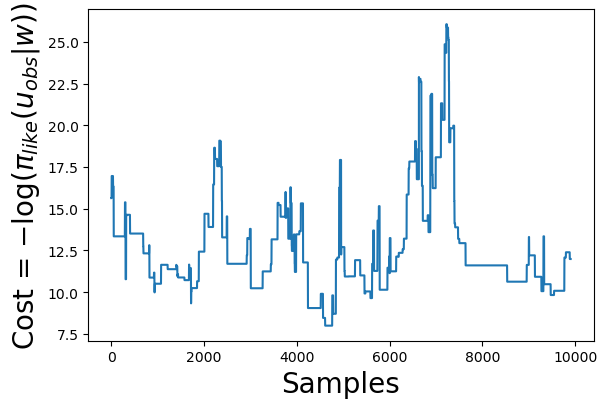

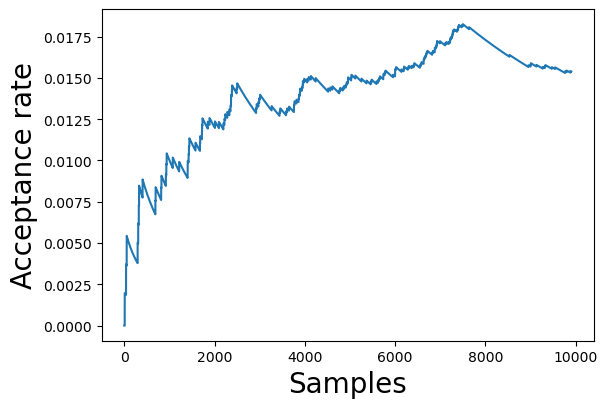

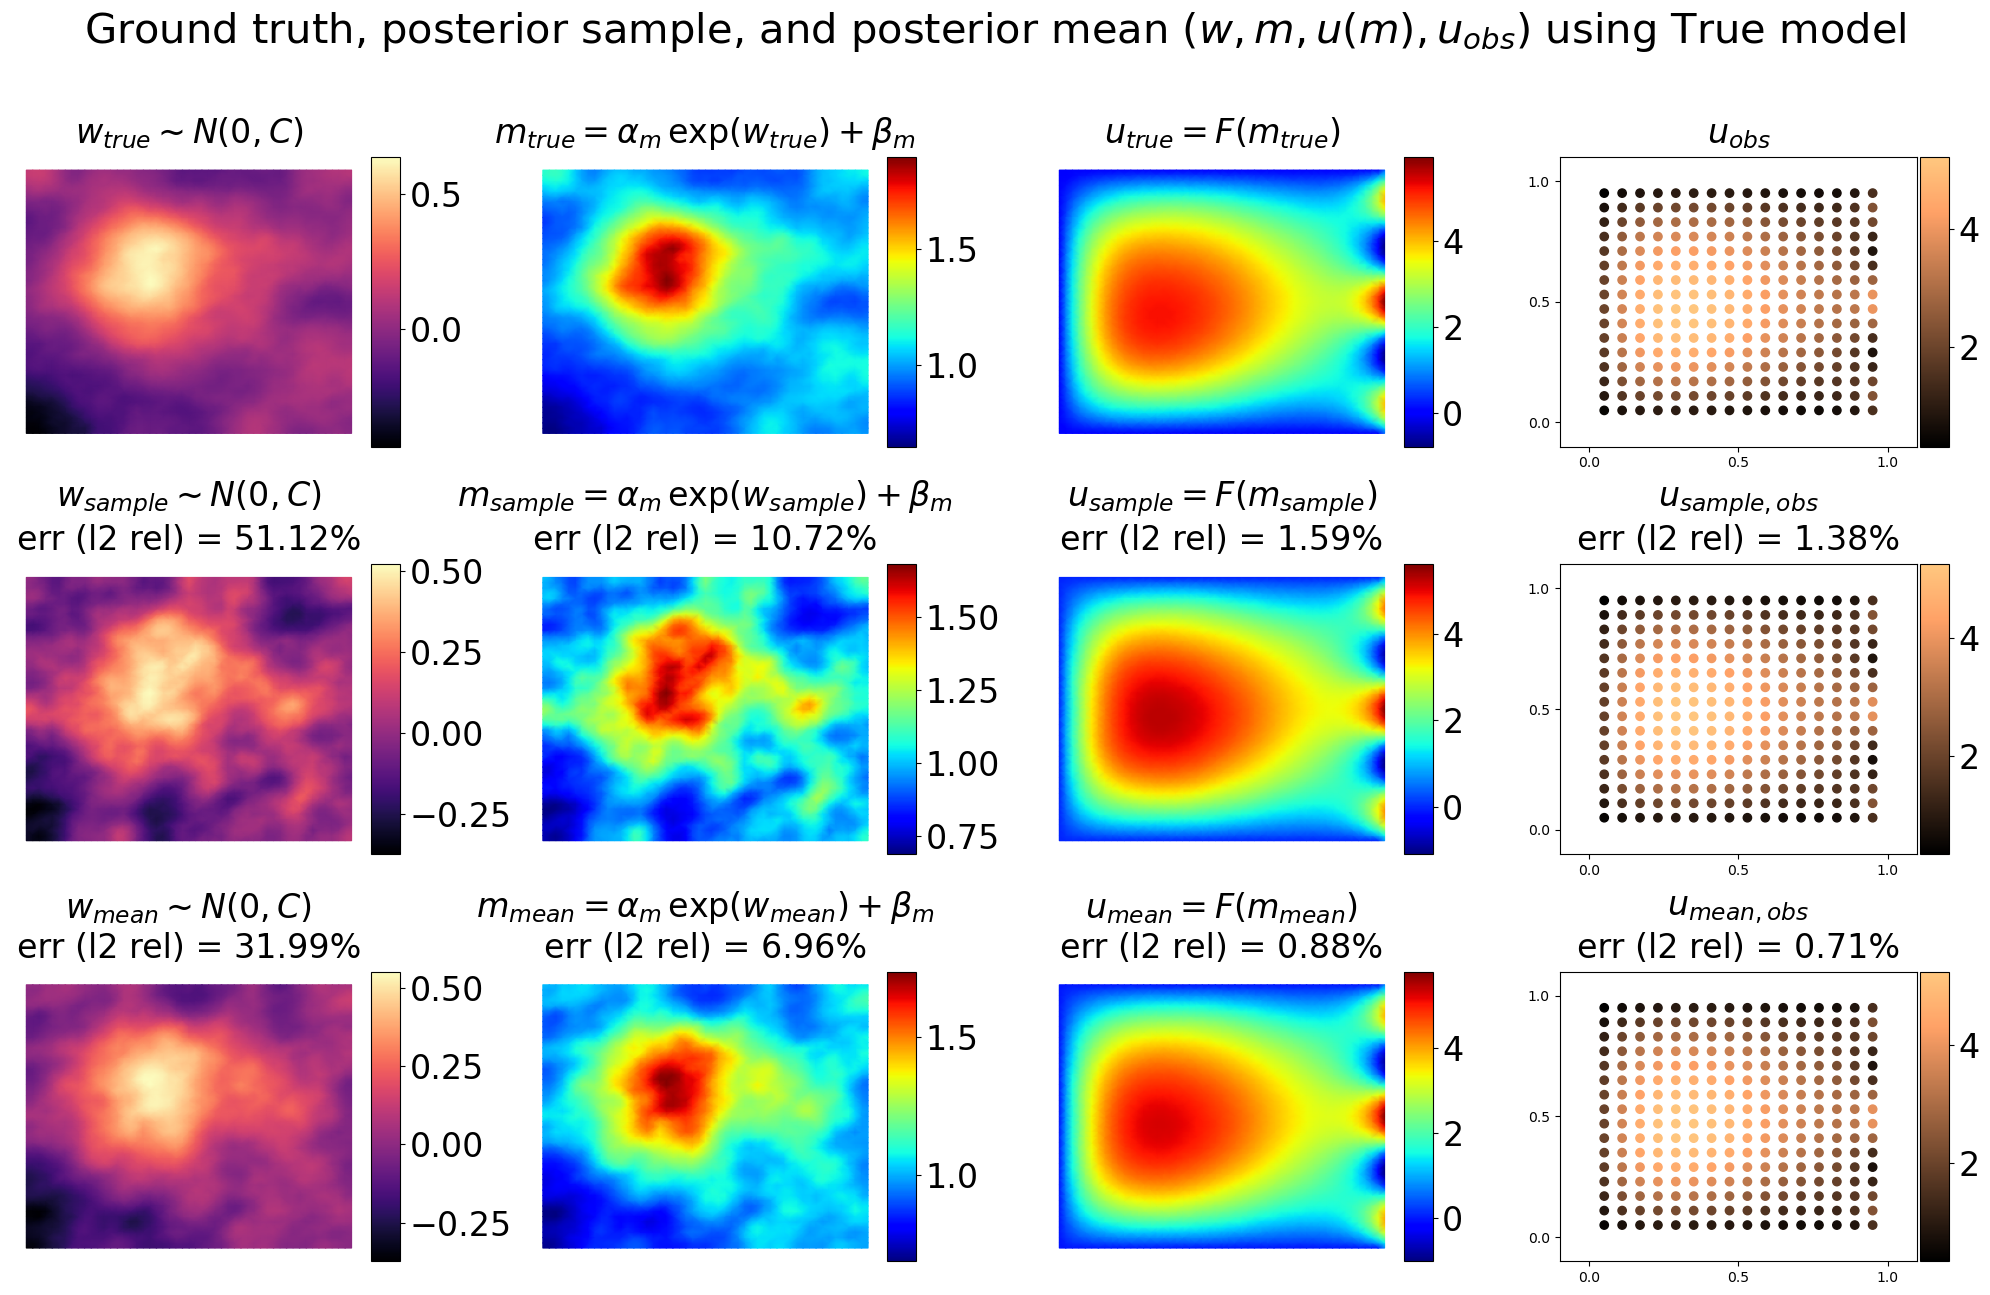

In [10]:
## plot
mcmc_pp_params = {'curve_plot': {'fs': 20, 'lw': 3, 'figsize': (6,4)}, \
                          'field_plot': {'fs': 24, 'y_sup_title': 1.075, 'figsize': (20, 12), 'ttl_pad': 10, 'u_vec_plot': True}}

savefig = True
pp_params = mcmc_pp_params['curve_plot']
plot_curve(tracer_true.accepted_samples_cost, xl=r'Samples', \
        yl= r'Cost = $-\log(\pi_{like}(u_{obs} | w))$', \
        fs = pp_params['fs'], lw = pp_params['lw'], figsize=pp_params['figsize'], \
                savefile = results_dir + 'cost_{}.png'.format(model_tag) if savefig else None)

plot_curve(tracer_true.acceptance_rate, xl=r'Samples', \
        yl= r'Acceptance rate', \
        fs = pp_params['fs'], lw = pp_params['lw'], figsize=pp_params['figsize'], \
                savefile = results_dir + 'acceptance_rate_{}.png'.format(model_tag) if savefig else None)


w_mean = tracer_true.accepted_samples_mean_m
w_sample_i = len(tracer_true.accepted_samples_m) - 1
w_sample = tracer_true.accepted_samples_m[w_sample_i]

pp_params = mcmc_pp_params['field_plot']
pp_params['sup_title'] = r'Ground truth, posterior sample' \
            + r', and posterior mean $(w, m, u(m), u_{obs})$ using True model'
mcmc_plot_fields_base(w_mean, w_sample, w_sample_i, mcmc, \
                      savefilename = results_dir + 'true_and_posterior_mean_w_m_u_{}.png'.format(model_tag) if savefig else None, \
                        params = pp_params)

# Load DeepONet model results

In [11]:
model_tag = 'DeepONet'
savepath_deeponet = savepath_base + '_surrogate_{}/'.format(model_tag)

## load tracer data
tracer_deeponet = pickle.load(open(savepath_deeponet + savefilename + '.pkl', 'rb'))
tracer_deeponet.acceptances, tracer_deeponet.acceptance_rate

(136,
 array([0.        , 0.        , 0.        , ..., 0.01307818, 0.01307692,
        0.01307567]))

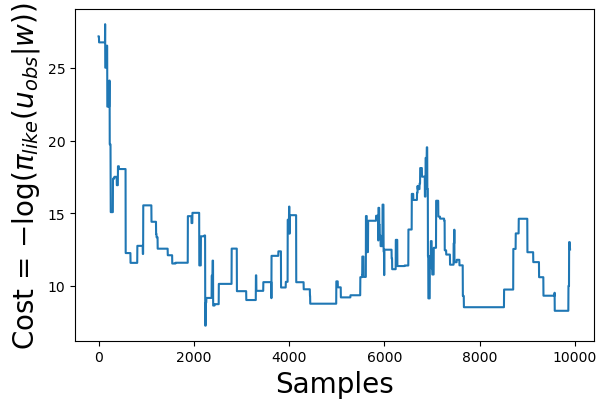

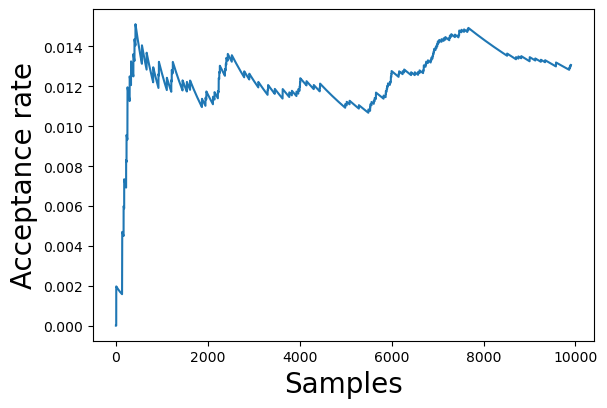

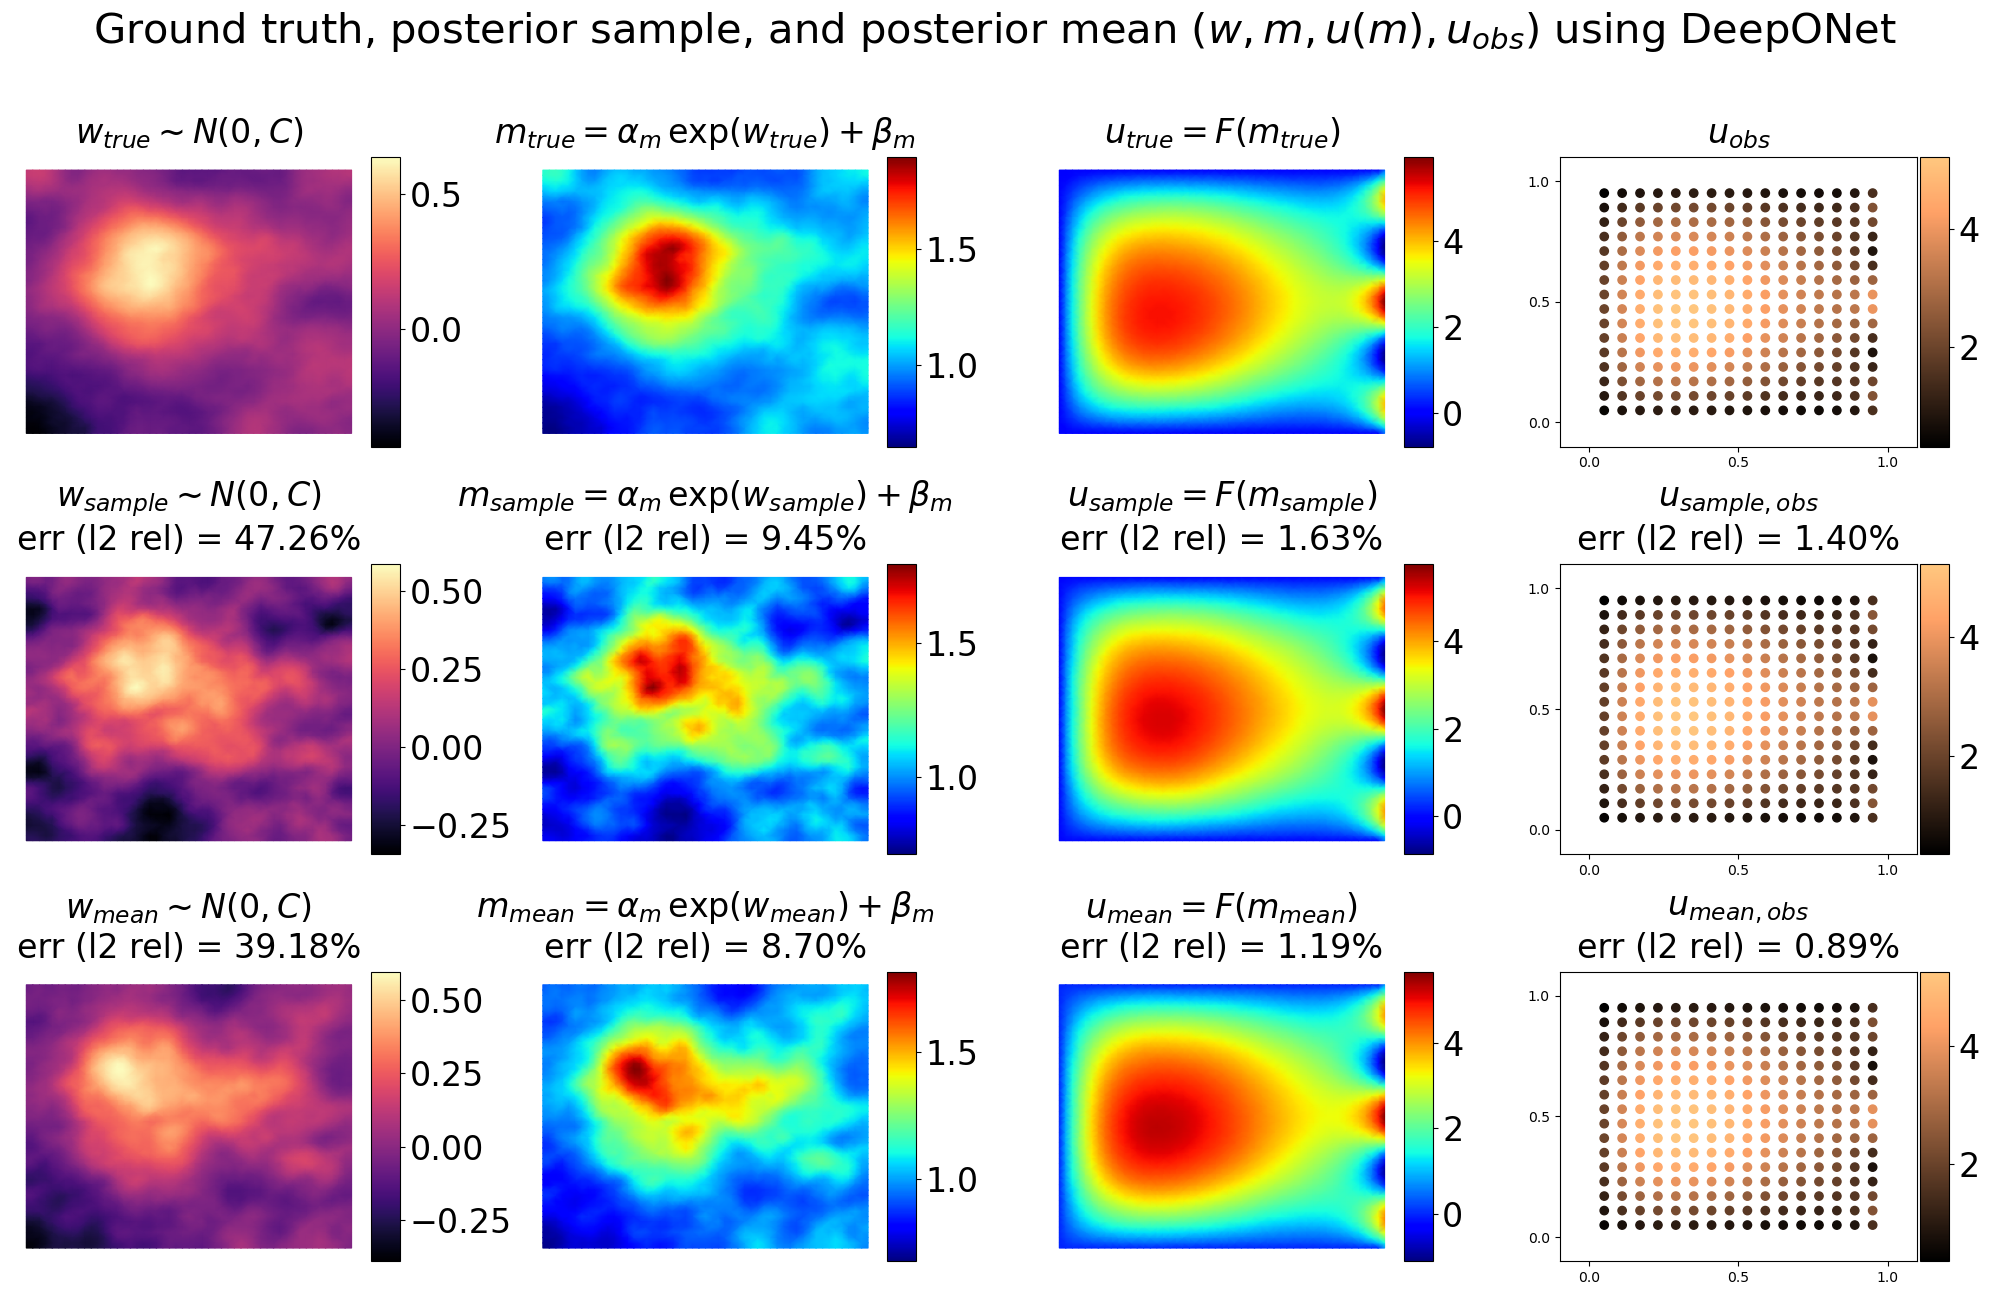

In [12]:
## plot
mcmc_pp_params = {'curve_plot': {'fs': 20, 'lw': 3, 'figsize': (6,4)}, \
                          'field_plot': {'fs': 24, 'y_sup_title': 1.075, 'figsize': (20, 12), 'ttl_pad': 10, 'u_vec_plot': True}}

savefig = True
pp_params = mcmc_pp_params['curve_plot']
plot_curve(tracer_deeponet.accepted_samples_cost, xl=r'Samples', \
        yl= r'Cost = $-\log(\pi_{like}(u_{obs} | w))$', \
        fs = pp_params['fs'], lw = pp_params['lw'], figsize=pp_params['figsize'], \
                savefile = results_dir + 'cost_{}.png'.format(model_tag) if savefig else None)

plot_curve(tracer_deeponet.acceptance_rate, xl=r'Samples', \
        yl= r'Acceptance rate', \
        fs = pp_params['fs'], lw = pp_params['lw'], figsize=pp_params['figsize'], \
                savefile = results_dir + 'acceptance_rate_{}.png'.format(model_tag) if savefig else None)


w_mean = tracer_deeponet.accepted_samples_mean_m
w_sample_i = len(tracer_deeponet.accepted_samples_m) - 1
w_sample = tracer_deeponet.accepted_samples_m[w_sample_i]

pp_params = mcmc_pp_params['field_plot']
pp_params['sup_title'] = r'Ground truth, posterior sample' \
            + r', and posterior mean $(w, m, u(m), u_{obs})$ using DeepONet'
mcmc_plot_fields_base(w_mean, w_sample, w_sample_i, mcmc, \
                      savefilename = results_dir + 'true_and_posterior_mean_w_m_u_{}.png'.format(model_tag) if savefig else None, \
                        params = pp_params)

# Load PCANet model results

In [13]:
model_tag = 'PCANet'
savepath_pcanet = savepath_base + '_surrogate_{}/'.format(model_tag)

## load tracer data
tracer_pcanet = pickle.load(open(savepath_pcanet + savefilename + '.pkl', 'rb'))
tracer_pcanet.acceptances, tracer_pcanet.acceptance_rate

(82,
 array([0.        , 0.        , 0.        , ..., 0.00788537, 0.00788462,
        0.00788386]))

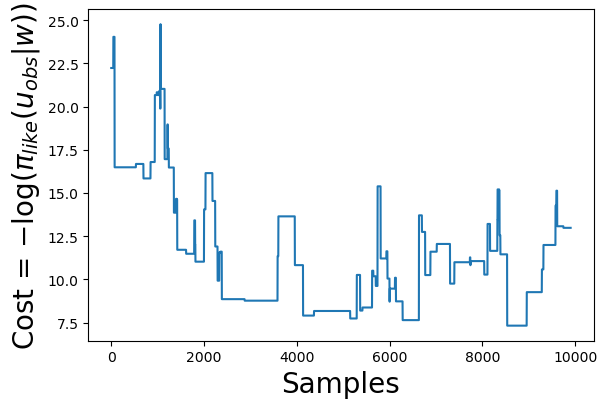

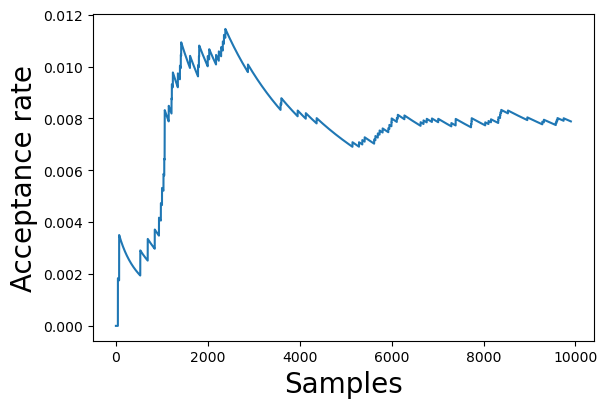

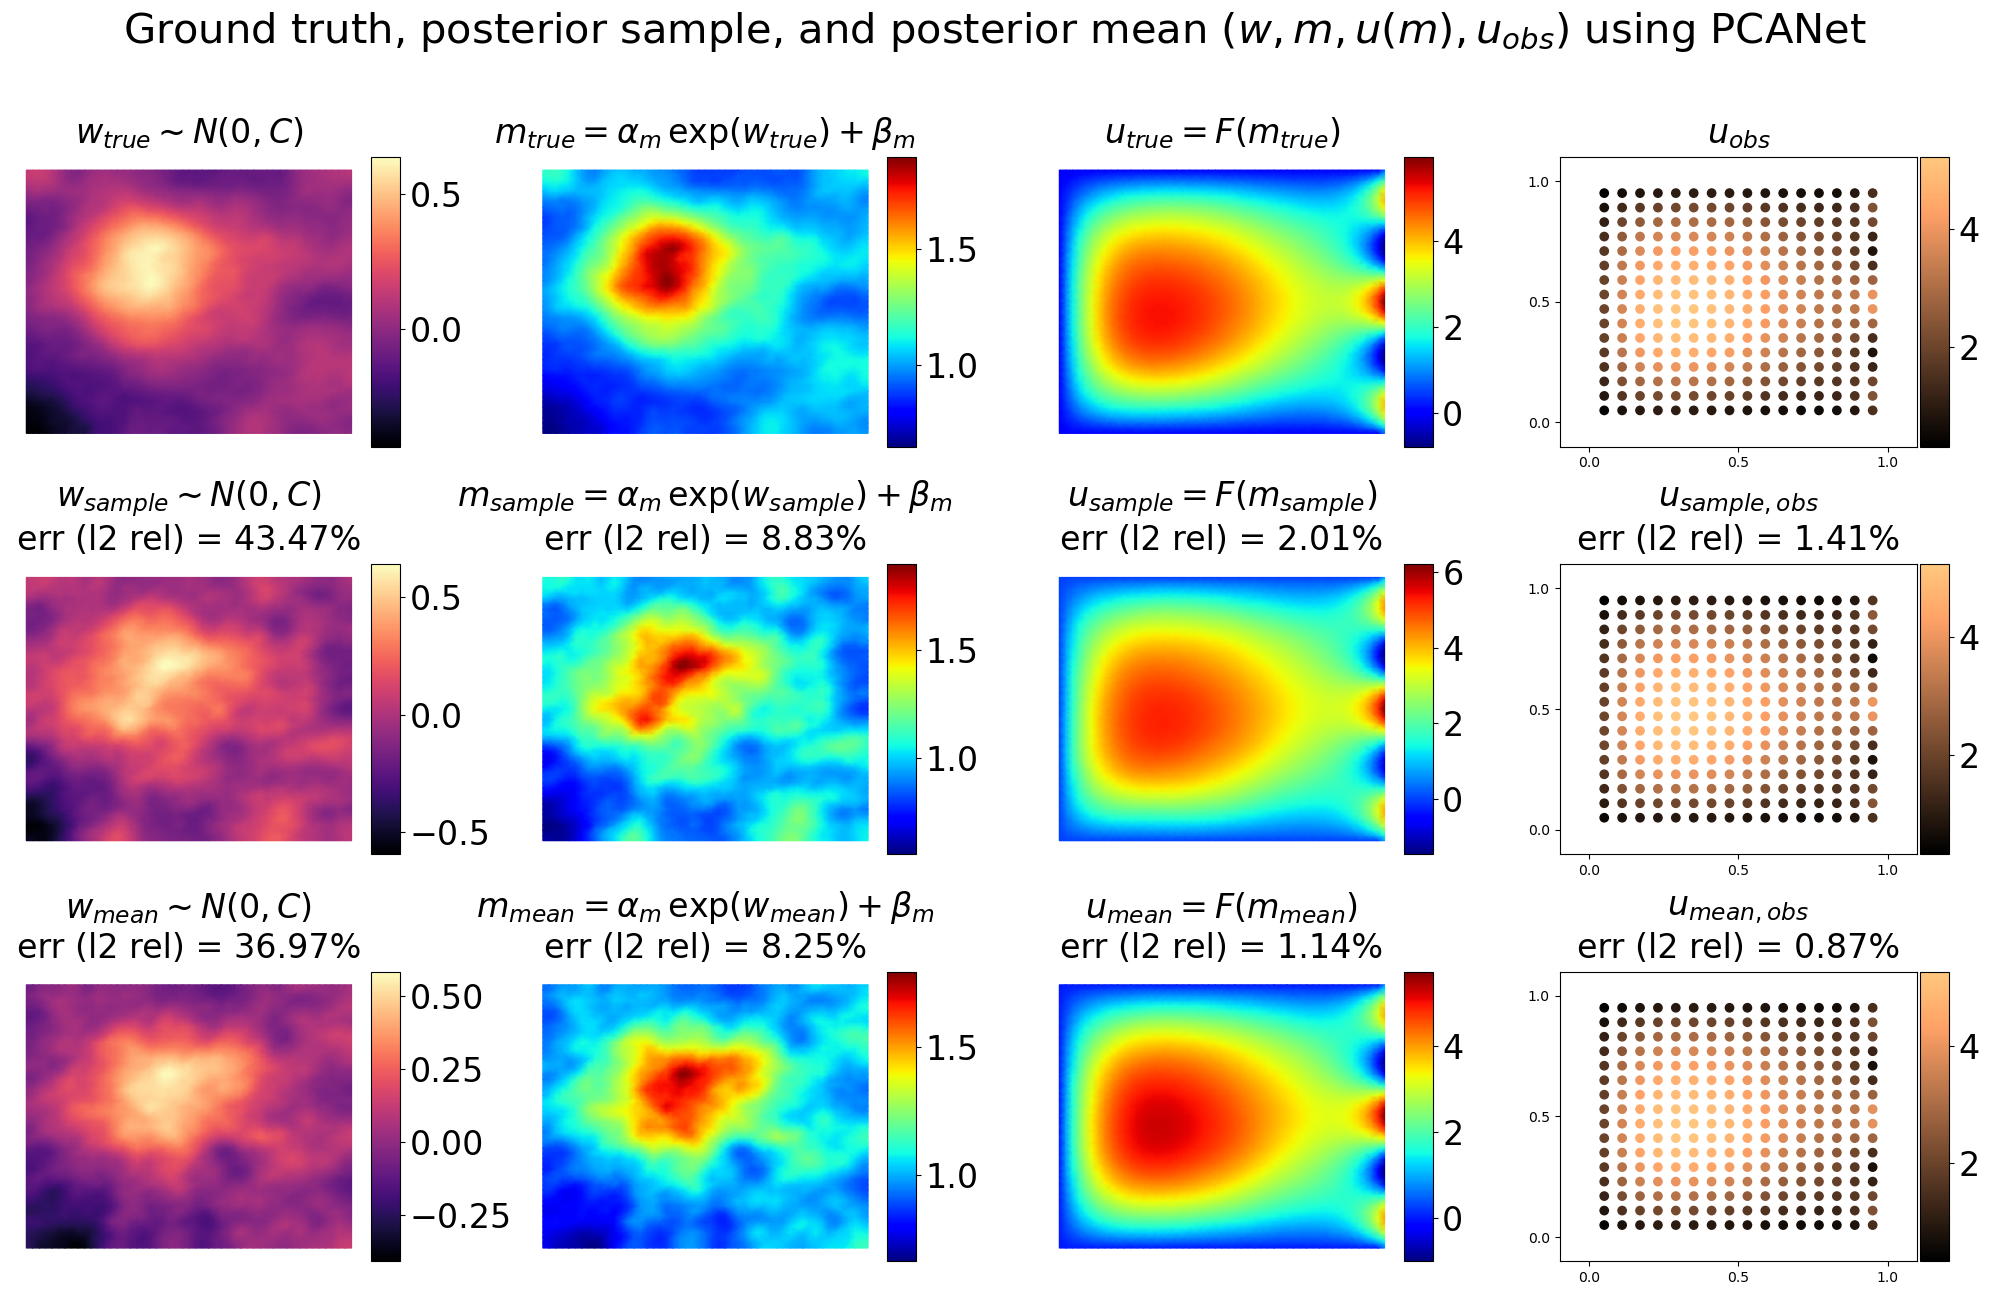

In [14]:
## plot
mcmc_pp_params = {'curve_plot': {'fs': 20, 'lw': 3, 'figsize': (6,4)}, \
                          'field_plot': {'fs': 24, 'y_sup_title': 1.075, 'figsize': (20, 12), 'ttl_pad': 10, 'u_vec_plot': True}}

savefig = True
pp_params = mcmc_pp_params['curve_plot']
plot_curve(tracer_pcanet.accepted_samples_cost, xl=r'Samples', \
        yl= r'Cost = $-\log(\pi_{like}(u_{obs} | w))$', \
        fs = pp_params['fs'], lw = pp_params['lw'], figsize=pp_params['figsize'], \
                savefile = results_dir + 'cost_{}.png'.format(model_tag) if savefig else None)

plot_curve(tracer_pcanet.acceptance_rate, xl=r'Samples', \
        yl= r'Acceptance rate', \
        fs = pp_params['fs'], lw = pp_params['lw'], figsize=pp_params['figsize'], \
                savefile = results_dir + 'acceptance_rate_{}.png'.format(model_tag) if savefig else None)


w_mean = tracer_pcanet.accepted_samples_mean_m
w_sample_i = len(tracer_pcanet.accepted_samples_m) - 1
w_sample = tracer_pcanet.accepted_samples_m[w_sample_i]

pp_params = mcmc_pp_params['field_plot']
pp_params['sup_title'] = r'Ground truth, posterior sample' \
            + r', and posterior mean $(w, m, u(m), u_{obs})$ using PCANet'
mcmc_plot_fields_base(w_mean, w_sample, w_sample_i, mcmc, \
                      savefilename = results_dir + 'true_and_posterior_mean_w_m_u_{}.png'.format(model_tag) if savefig else None, \
                        params = pp_params)

# Load FNO model results

In [15]:
model_tag = 'FNO'
savepath_fno = savepath_base + '_surrogate_{}/'.format(model_tag)

## load tracer data
tracer_fno = pickle.load(open(savepath_fno + savefilename + '.pkl', 'rb'))
tracer_fno.acceptances, tracer_pcanet.acceptance_rate

(135,
 array([0.        , 0.        , 0.        , ..., 0.00788537, 0.00788462,
        0.00788386]))

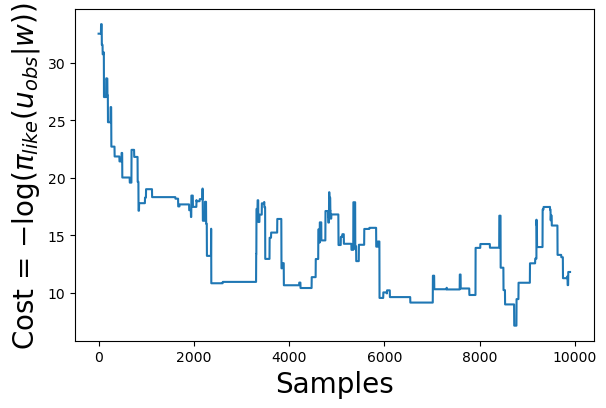

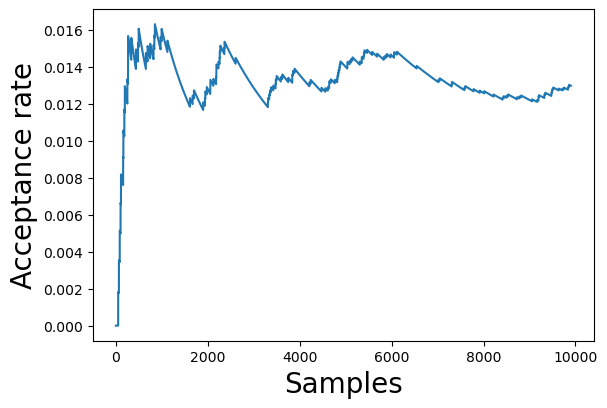

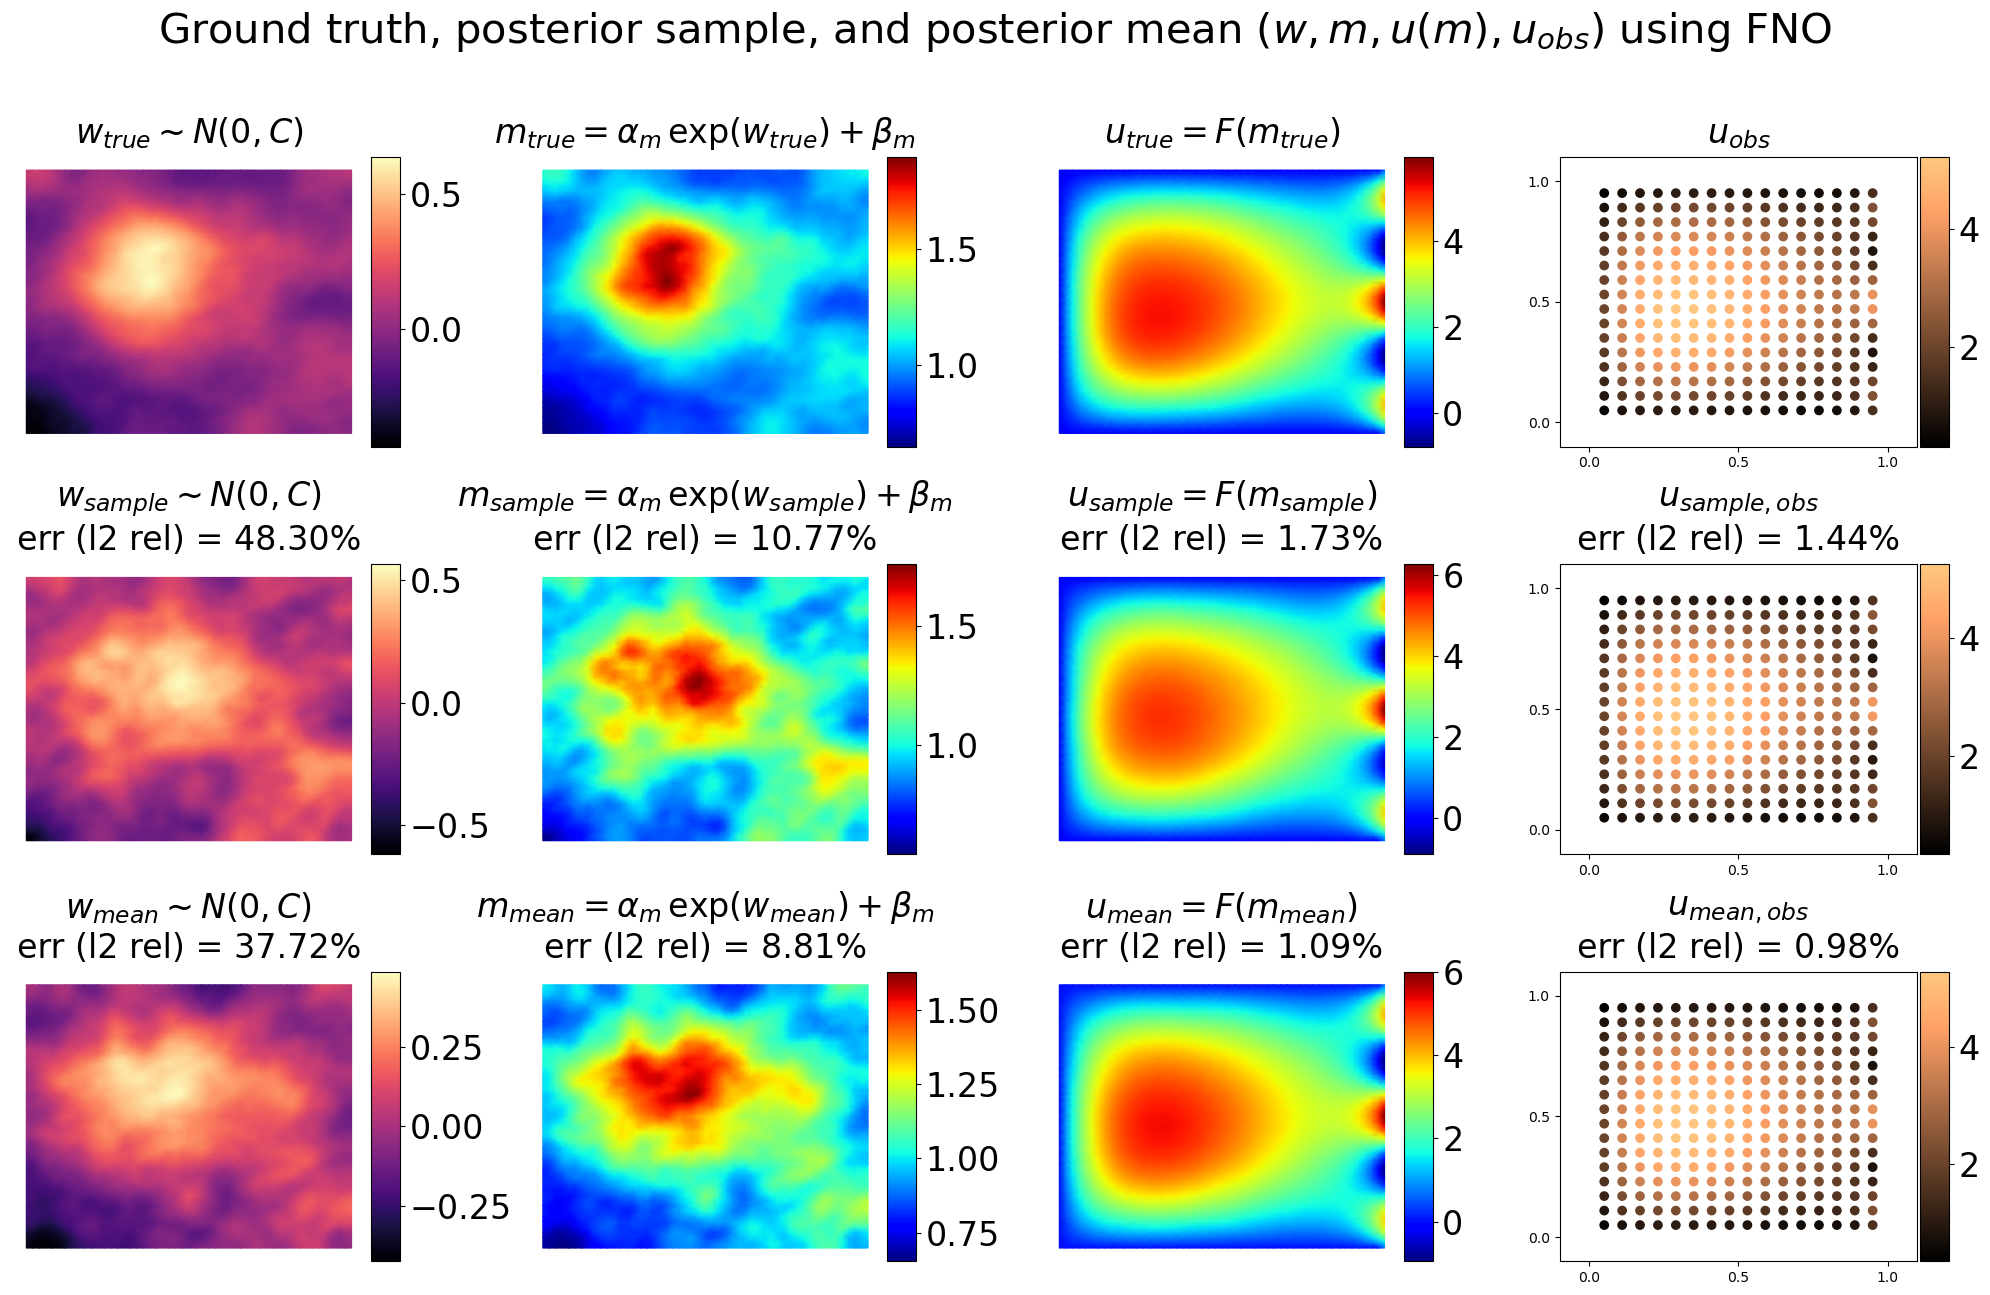

In [16]:
## plot
mcmc_pp_params = {'curve_plot': {'fs': 20, 'lw': 3, 'figsize': (6,4)}, \
                          'field_plot': {'fs': 24, 'y_sup_title': 1.075, 'figsize': (20, 12), 'ttl_pad': 10, 'u_vec_plot': True}}

savefig = True
pp_params = mcmc_pp_params['curve_plot']
plot_curve(tracer_fno.accepted_samples_cost, xl=r'Samples', \
        yl= r'Cost = $-\log(\pi_{like}(u_{obs} | w))$', \
        fs = pp_params['fs'], lw = pp_params['lw'], figsize=pp_params['figsize'], \
                savefile = results_dir + 'cost_{}.png'.format(model_tag) if savefig else None)

plot_curve(tracer_fno.acceptance_rate, xl=r'Samples', \
        yl= r'Acceptance rate', \
        fs = pp_params['fs'], lw = pp_params['lw'], figsize=pp_params['figsize'], \
                savefile = results_dir + 'acceptance_rate_{}.png'.format(model_tag) if savefig else None)


w_mean = tracer_fno.accepted_samples_mean_m
w_sample_i = len(tracer_fno.accepted_samples_m) - 1
w_sample = tracer_fno.accepted_samples_m[w_sample_i]

pp_params = mcmc_pp_params['field_plot']
pp_params['sup_title'] = r'Ground truth, posterior sample' \
            + r', and posterior mean $(w, m, u(m), u_{obs})$ using FNO'
mcmc_plot_fields_base(w_mean, w_sample, w_sample_i, mcmc, \
                      savefilename = results_dir + 'true_and_posterior_mean_w_m_u_{}.png'.format(model_tag) if savefig else None, \
                        params = pp_params)

## Plot acceptance rate and cost for all

In [17]:
def plot_curve_multi(data, x = None, xl = None, yl = None, \
               fs = 20, lw = 2, lclr = None, \
               l_lbl = None, \
               title = None, \
               savefile = None, \
               figsize = [10,10]):
    
    fig, ax = plt.subplots(figsize=figsize)

    x = np.arange(len(data[0])) if x is None else x
    lclr_vec = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
    if lclr is not None:
        if len(lclr) == 1:
            lclr_vec = [lclr for i in range(len(data))]
        else:
            lclr_vec = lclr

    for i in range(len(data)):
        if l_lbl is not None and i < len(l_lbl):
            ax.plot(x, data[i], lw = lw, color = lclr_vec[i], label = l_lbl[i])
        else:
            ax.plot(x, data[i], lw = lw, color = lclr_vec[i])

    if xl is not None:
        ax.set_xlabel(xl, fontsize = fs)
    if yl is not None:
        ax.set_ylabel(yl, fontsize = fs)

    if l_lbl is not None:
        ax.legend(fontsize = fs, fancybox = True, frameon = True)

    if title is not None:
        ax.set_title(title, fontsize = fs)
        
    plt.tight_layout(pad=0.4)
    if savefile is not None:
        plt.savefig(savefile)
    plt.show()

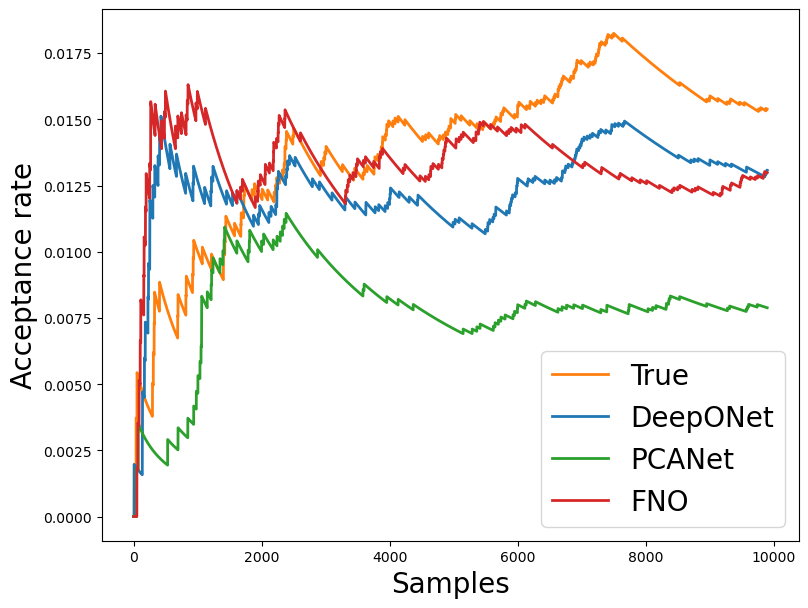

In [20]:
plot_data = [tracer_true.acceptance_rate, tracer_deeponet.acceptance_rate, tracer_pcanet.acceptance_rate, tracer_fno.acceptance_rate]
lclr = ['tab:orange', 'tab:blue', 'tab:green', 'tab:red']
l_lbl = ['True', 'DeepONet', 'PCANet', 'FNO']
savefile = results_dir + 'acceptance_rate_comparison.png'

plot_curve_multi(plot_data, fs = 20, figsize = [8, 6],\
                 xl=r'Samples', yl= r'Acceptance rate', \
                 lclr = lclr, l_lbl = l_lbl, savefile = savefile)

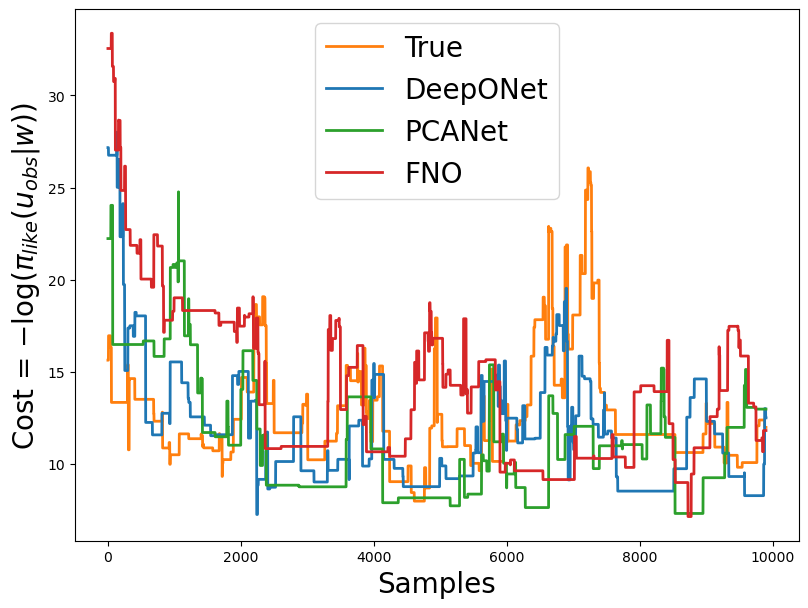

In [21]:
plot_data = [tracer_true.accepted_samples_cost, tracer_deeponet.accepted_samples_cost, tracer_pcanet.accepted_samples_cost, tracer_fno.accepted_samples_cost]
lclr = ['tab:orange', 'tab:blue', 'tab:green', 'tab:red']
l_lbl = ['True', 'DeepONet', 'PCANet', 'FNO']
savefile = results_dir + 'cost_comparison.png'

plot_curve_multi(plot_data, fs = 20, figsize = [8, 6],\
                 xl=r'Samples', yl= r'Cost = $-\log(\pi_{like}(u_{obs} | w))$', \
                 lclr = lclr, l_lbl = l_lbl, savefile = savefile)